In [1]:
import os
url = 'NYU_Hazy'
fileList = []
def getAllFile(path, fileList):
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.bmp'):
                fileList.append(root +'/'+ file)
if __name__ == '__main__':
    getAllFile(url, fileList)

In [2]:
import cv2;
import math;
import numpy as np;

def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz);
    imvec = im.reshape(imsz,3);

    indices = darkvec.argsort();
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
       atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

def TransmissionEstimate(im,A,sz):
    omega = 0.95;
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);

    return t;

def Recover(im,t,A,tx = 0.1):
    res = np.empty(im.shape,im.dtype);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

    return res

In [3]:
import sys
if __name__ == '__main__':
    for i in range(len(fileList)):
        fn=fileList[i]
        src = cv2.imread(fn);
        I = src.astype('float64')/255;
        dark = DarkChannel(I,15);
        A = AtmLight(I,dark);
        te = TransmissionEstimate(I,A,15);
        t = TransmissionRefine(src,te);
        J = Recover(I,t,A,0.1);
        url="NYU/"+fileList[i].replace(".bmp",".png")
        cv2.imwrite(fileList[i].replace("NYU_Hazy","NYU").replace(".bmp",".png"),J*255);
        cv2.waitKey();

(-0.5, 639.5, 479.5, -0.5)

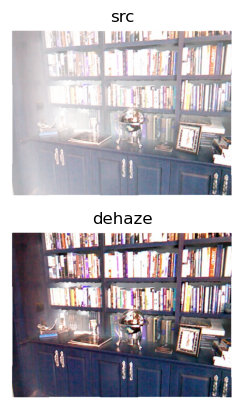

In [4]:
import random
import matplotlib.pyplot as plt
a=random.choice(fileList)
b=a.replace("NYU_Hazy","NYU").replace(".bmp",".png")
#axis_py=plt.figure().subplots(1,2)
a=cv2.imread(a)
src=a.astype('float64')/255
b=cv2.imread(b)
image_haze=b.astype('float64')/255
image=plt.figure().subplots(2)
image[0].imshow(src);image[0].set_title("src");image[0].axis("off")
image[1].imshow(image_haze);image[1].set_title("dehaze");image[1].axis("off")
